## Churn prediction

### Part 2: Churn prediction  in the bank customers

The project concerns churn prediction in the bank customers. Based on data I have tried to predict whether the client is going to leave the bank or not by using information like credit score, tenure, salary, etc. Project includes data analysis, data preparation and created model by using different machine learning algorithms such Logistic Regression, Random Forest, KNN, Ada Boost and XGBoost.

Churn is a term that means losing customers to the competition. A “Churned” customer is one who has cancelled their service and identification of such users beforehand can be invaluable from the company's point of view. It is very important because retain customers who want to leave us is in many cases much cheaper than acquiring new ones.

### Dataset

The dataset contains the details of the customers in a bank company such as credit score, estimated salary, age, sex, etc. It comes from Kaggle. 

Attributes:

- RowNumber - number
- CustomerId - id 
- Surname - customer surname
- CreditScore - credict score of client
- Geography - region
- Gender - gender of customer
- Age - age of customer
- Tenure - duration of the agreement 
- Balance - bank balance 
- NumOfProducts - number of products / services 
- HasCrCard - customer have a credit card or not
- IsActiveMember - active customers or not 
- EstimatedSalary - estimated salary 
- Exited - churn

## Import libriaries and data

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

# Model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

import pickle
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('C:\Python Scripts\Datasets\churn\Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


First observations:

In [4]:
print(f'Shape of data:', df.shape)

Shape of data: (10000, 14)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Ccolumns:

In [6]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Checking the missing values in data:

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Number of unique values in Geography variable:

In [8]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

The dataset includes information about 10000 customers placed in  14 columns. The atribute "Exited" is our churn and shows about whether the client resigned from the bank's services or not. After first observations one can see that there are no missing values. The column names are explicit, so it can easily infer that what are in this dataset. 

## Basic data anaysis

In the data churn is marked as Exited where 1 = churn and 0 = no churn. 

What part of the set is churn?

In [37]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

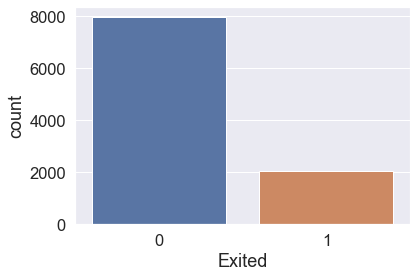

In [38]:
sns.set(font_scale=1.5)
sns.countplot(x=df['Exited'])
plt.show()

In percentage terms:

In [10]:
percent = df.groupby('Exited')['Exited'].count() / df.shape[0] * 100
percent

Exited
0    79.63
1    20.37
Name: Exited, dtype: float64

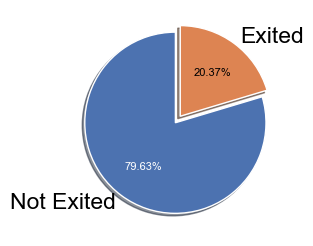

In [11]:
labels = ['Not Exited', 'Exited']
fig, ax = plt.subplots(figsize = (4, 3), dpi = 100)
explode = (0, 0.09)

patches, texts, autotexts = ax.pie(percent, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 90, explode = explode)

plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 8, color = 'white')
autotexts[1].set_color('black')
plt.show()

One can see 20% of the customers have churned and 80% haven't.

The above analysis showed that the data is imbalanced, more customers stay than those who leave. I will need to include this when building models and their evaluation.

## Data cleaning

First I deleting unnecessary columns such as "CustomerId", "Surname" and "RowNumber" because they do not have any logical contribution for prediction. I also convert non numeric features to numeric features. 

In [9]:
data = df.drop(['CustomerId','Surname','RowNumber'],axis=1)

In [10]:
data['Gender'] = data['Gender'].map({'Male' : 0, 'Female' : 1})

In [11]:
data = pd.get_dummies(data, columns = ['Geography'])

In [12]:
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


### Data preparation

**Spliting data into train and test set.**

The data are exhibit a large imbalance in the distribution of the target classes hence I have to maintain the class proportion in the train-test sets.  For this purpose I have used stratified sampling to ensure relative class frequencies is approximately preserved in each train and validation fold.

Stratification makes even distribution of the target(label) in the train and test set - just as it is distributed in the original dataset. For example the target column for the training set has 80% of 'yes' and 20% of 'no', and also, the target column for the test set has 80% of 'yes' and 20% of 'no' respectively.

In [13]:
X = data.drop('Exited', axis=1)
Y = data['Exited']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)

**Scaling data**

I scale the data so that data points are on the same level.

In [15]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Build models

The churn is not simple to predict. Deciding to churn is often subjective. The one client may churn because of costs issues and other may churn because of quality. In addition bad customer service also may trigger the decision to churn subjectively. 

One of the most common classification evaluation metric is accuracy, i.e. the number of correct predictions made as a ratio of total predictions. However, it's not the ideal metric when we have class imbalance issue. Because the dataset is unbalanced I have used cross validation method to sort our results. To measure models performances I have used the 'roc auc score'. 

### Model Evaluation

To evaluate the models I have used K-fold Cross Validation, Roc Auc Score, ROC curve and Confusion Matrix.

**K-fold cross validation** is the most commonly used form of validation. K-fold validation evaluates the data across the entire training set, dataset is divided into k subsets and the method is repeated k times. Each time one of the k subset is used for test set and others are training set. Then average accuracy across all k trials is computed. 

**ROC curve** (Receiver Operating Characteristic curve) is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis). It describes how good the model is at predicting the positive class when the actual outcome is positive. 
The shape of the curve shows the expected false positive rate and the false negative rate. Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives while larger values on the y-axis of the plot indicate higher true positives and lower false negatives. Put another way if the curve in plot is closer to left-top corner test is more accurate.

The **roc auc score (AUC)** is the  computation area under the curve from prediction scores. It can be used as summary of the model skill. The higher AUC value, the more efficient the classifier is, i.e. the closer to 1 the auc is the better.

I test a few models for resolve the problem:

- Logistic Regression,
- Random Forest,
- K-Nearest Neighbors,
- Ada Boost,
- XGBoost.

At the beginning I create some useful functions:

In [16]:
def plot_conf_matrix(pred_set):
    """The function to plot confusion matrix"""
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confusion_matrix(y_test, pred_set),
                annot=True,fmt = "0.1f",linecolor="k",linewidths=3)
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))   

    plt.title("Confusion Matrix",fontsize=14)
    plt.show()
    

def plot_roc_curve(model):
    """The function to plot roc curve"""
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr, tpr, label='ROC' ,color = 'red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve',fontsize=16)
    plt.legend()
    plt.show()
    

def acc_score(model):
    """The function to calculate accuracy score"""
    acc = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    score = round(acc.mean(), 2)
    return score


def roc_score(model):
    """Roc auc score calculation"""
    pred_prob = model.predict_proba(X_test)
    score = roc_auc_score(y_test, pred_prob[:,1])
    auc_score = round(score, 2)
    return auc_score

**1. Logistic regression**

In [17]:
logReg = LogisticRegression(random_state=0)
logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)

Evaluation:

In [18]:
acc_log = acc_score(logReg)
print('Accuracy score: %s' % acc_log)

roc_log = roc_score(logReg)
print('ROC AUC: %s' % roc_log)

Accuracy score: 0.81
ROC AUC: 0.77


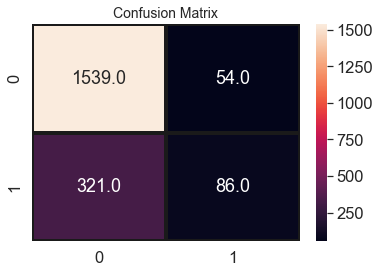

In [39]:
plot_conf_matrix(y_pred)

**2. Random Forest Classifier**

In [20]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=0)
model_rf.fit(X_train, y_train)

pred_y = model_rf.predict(X_test)

Evaluation:

In [21]:
acc_rf = acc_score(model_rf)
print('Accuracy score: %s' % acc_rf)

roc_rf = roc_score(model_rf)
print('ROC AUC: %s' % roc_rf)

Accuracy score: 0.86
ROC AUC: 0.86


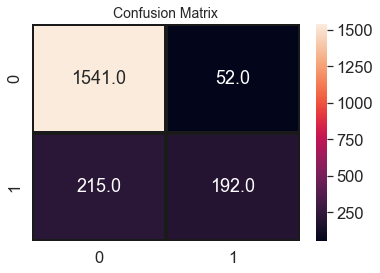

In [40]:
plot_conf_matrix(pred_y)

Roc curve for Random Forest model:

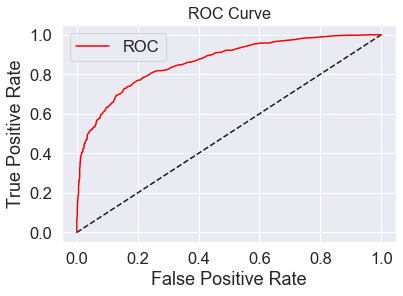

In [41]:
plot_roc_curve(model_rf)

**3. K-Nearest Neighbors**

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=20, metric="minkowski", p=2) 
knn_model.fit(X_train,y_train)

pred = knn_model.predict(X_test)

Evaluation:

In [24]:
acc_knn = acc_score(knn_model)
print('Accuracy score: %s' % acc_knn)

roc_knn = roc_score(knn_model)
print('ROC AUC: %s' % roc_knn)

Accuracy score: 0.83
ROC AUC: 0.81


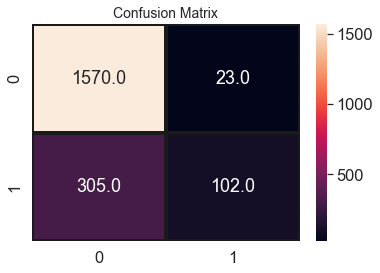

In [42]:
plot_conf_matrix(pred)

**4. AdaBoost Classifier**

In [26]:
ada_model = AdaBoostClassifier(n_estimators=200 ,random_state=0)
ada_model.fit(X_train,y_train)

preds = ada_model.predict(X_test)

Evaluation:

In [28]:
acc_ada = acc_score(ada_model)
print('Accuracy score: %s' % acc_ada)

roc_ada = roc_score(ada_model)
print('ROC AUC: %s' % roc_ada)

Accuracy score: 0.85
ROC AUC: 0.84


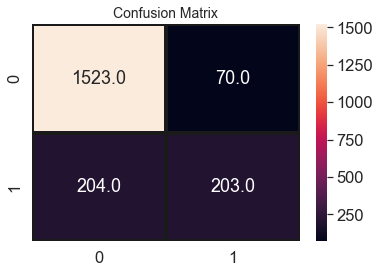

In [43]:
plot_conf_matrix(preds)

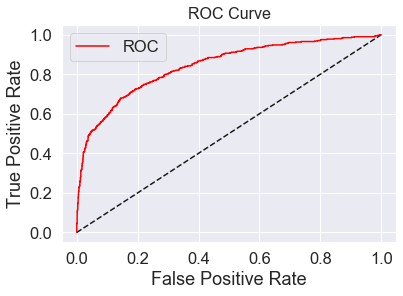

In [44]:
plot_roc_curve(ada_model)

**5. XGBoost Classifier**

In [30]:
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train, y_train)

predict = xgb.predict(X_test)

[17:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Evaluation:

In [31]:
acc_xgb = acc_score(xgb)
print('Accuracy score: %s' % acc_xgb)

[17:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [32]:
roc_xgb = roc_score(xgb)
print('ROC AUC: %s' % roc_xgb)

ROC AUC: 0.85


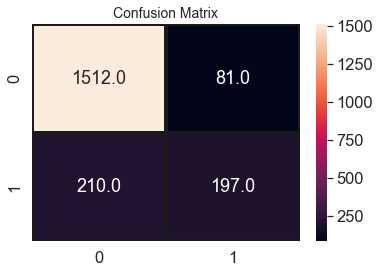

In [45]:
plot_conf_matrix(predict)

Roc curve for XGBoost model:

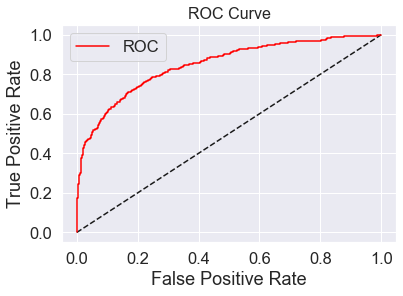

In [46]:
plot_roc_curve(xgb)

### Feature Evaluation

I check which features play the most important role in the identification of customer churn. I use an attribute named feature_importance that contains information about the most important features for a given classification. The best model is Random Forest one and I use it for analysis.

The following code creates a plot of the top 10 features for predicting customer churn:

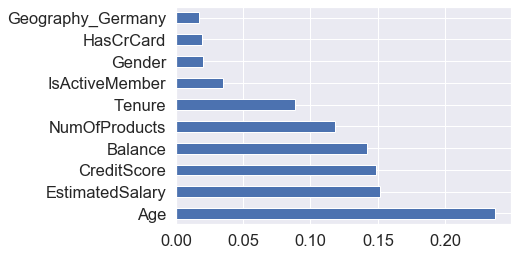

In [46]:
rf_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
rf_importances.nlargest(10).plot(kind='barh')

Based on this data one can see that Age has the highest impact on customer churn, followed by a customer's estimated salary and Credit Score.

### Best model

I have tested five different models and check which one is the best:

In [47]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Random Forest', 'KNN', 'AdaBoost', 'XGBoost'],
                      'ROC_AUC': [roc_log, roc_rf, roc_knn, roc_ada, roc_xgb],
                      'Accuracy_score': [acc_log, acc_rf, acc_knn, acc_ada, acc_xgb]})

models.sort_values(by='ROC_AUC', ascending=False)

,Model,ROC_AUC,Accuracy_score
1,Random Forest,0.86,0.86
4,XGBoost,0.85,0.85
3,AdaBoost,0.84,0.85
2,KNN,0.81,0.83
0,Logistic Regression,0.77,0.81


From above analysis one can see that the best model is Random Forest with ROC AUC score of 86% and accuracy score of 86%. This model has achaived the best result both in ROC AUC score and Accuracy score and this is signalling the characteristics of a reasonably good model with comparision to others ones.

**Interpreting the ROC curve:**

The ROC curve graph shows the capability of a model to distinguish between the classes based on the AUC Mean score. The dashed line represents the ROC curve of a random classifier where a good classifier tries to remain as far away from that line as possible. As shown in the graph below the Random Forest model showcased a higher AUC score near to left-top corner.

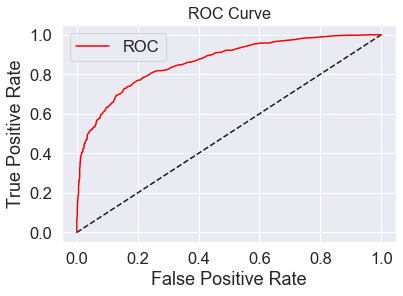

In [48]:
# ROC curve of Ranfom Forest
plot_roc_curve(model_rf)

**Interpreting the confusion matrix of the best model:**

The Confusion matrix indicates that we have 192+1541 correct predictions and 215+52 incorrect ones. One can say that the model predicted 244 customers churning of those 192 did and 52 stayed. In the other hand the 407 customers that actually churned, 215 were predicted to stay. 


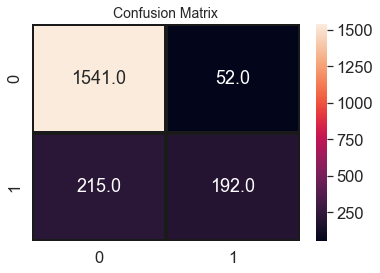

In [49]:
#Random Forest confusion matrix
plot_conf_matrix(pred_y)  

In [52]:
# Save the best model
with open("rf_model.pkl", "wb") as model_file:
    pickle.dump(model_rf, model_file)

## Summary

This project was aimed to churn prediction in the bank customers. I started with data analysis to better meet the data. Then I cleaned data and prepared to the modelling. Following I have used five different classification models such as Logistic Regression, KNN, Random Forest, Ada Boost and XGBoost to achaived the best model. Finally I evaluated models with a few methods to check which model is the best. I have used a ROC AUC score, k-fold Cross Validation, ROC curve and confusion matrix. After checked all of this metrics the best classification algorithm that I got is Random Forest with ROC AUC score 85%. It is a reasonably good model but it could be made a many improvement such as tuning the hyperparameter etc. to achaived a better results.